## The Room 2 - Room Harder

In [1]:
from fastai.text import *
import html
import pandas as pd

In [2]:
#BOS = 'xbos'  # beginning-of-sentence tag
#FLD = 'xfld'  # data field tag
PATH=Path('data/the_room/')
#PATH=Path('data/imdb/aclImdb/')

In [3]:
CLAS_PATH=Path('data/the_room/the_room_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/the_room/the_room_lm/')
LM_PATH.mkdir(exist_ok=True)

In [4]:
df = pd.read_csv(f'{PATH}/the_room.csv', engine='python', header=None)

In [5]:
text = df.values.flatten().tolist()

In [6]:
text = [line + "\n" for line in text]   

In [7]:
text_line_length = len(text)
trn_index = int(text_line_length*1.0)
trn = text[:trn_index]
tst = text[trn_index:]
with open('data/the_room/trn/trn.txt','w') as f2:
    f2.writelines(trn)
with open('data/the_room/val/val.txt','w') as f3:
    f3.writelines(tst)  

In [8]:
!ls {PATH}

models	       the_room.csv  the_room_script.txt  trn
the_room_clas  the_room_lm   tmp		  val


In [9]:
len(trn)

1100

In [10]:
col_names = ['text']

In [11]:
d = {'labels': 0, 'text': trn}

In [12]:
train_df = pd.DataFrame(data=d)

In [13]:
trn_texts = np.array(train_df['text'])
val_texts = np.array(train_df['text'])

In [14]:
trn_texts

array(['Wiseau Films logo\n',
       'Opening credits play against generic footage of Johnny stalking about San Francisco\n',
       'Exterior shot of Johnny�s car pulling up outside his house\n', ...,
       'Denny: Why, Johnny? Why? Johnny, why? Why?\n',
       'Denny sobs. Mark and Lisa, who were in the process of leaving, rejoin Denny and comfort him. We hear police sirens. The three of them appear to take turns fellating Johnny�s corpse as we hear generic police chatter.\n',
       'Fade to black and roll credits.\n'], dtype=object)

In [163]:
df_trn = trn_texts
df_val = val_texts

We start by creating the data for the Language Model(LM). The LM's goal is to learn the structure of the english language. It learns language by trying to predict the next word given a set of previous words(ngrams). Since the LM does not classify reviews, the labels can be ignored.

The LM can benefit from all the textual data and there is no need to exclude the unsup/unclassified movie reviews.

We first concat all the train(pos/neg/unsup = **75k**) and test(pos/neg=**25k**) reviews into a big chunk of **100k** reviews. And then we use sklearn splitter to divide up the 100k texts into 90% training and 10% validation sets.

In [164]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [165]:
len(trn_texts), len(val_texts)

(990, 110)

In [166]:
trn_texts

array(['Mark: Fuck!\n', 'Lisa: I still love you.\n', 'Johnny: Hello Michelle. I heard you. What secret?\n',
       'Mike: I dunno, uh, a couple hours? At least.\n', 'Mark: Come on! Come on! Come on!\n',
       'Claudette: Well, sure, I can come. But I don�t know if I�ll bring anybody. Oh! That jerk Harold. He wants me to give him a share of my house. That house belongs to me. He has no right. I�m not giving him a penny. Who does he think he is?\n',
       'Lisa: He�s so boring.\n', 'Johnny: In a few minutes, bitch.\n',
       'Lisa: Did you tell them how much you save them?\n',
       'Lisa: He still won�t come out of the bathroom.\n', 'Denny: What�s happening?!\n',
       'Denny: What�s wrong with Mark?\n', 'Denny: Catch, Mark!\n', 'Lisa: No. I don�t know what to do.\n',
       'Mark slowly kisses Johnny�s forehead.\n', 'Johnny: You know better, Denny, you almost got killed.\n',
       'Chris-R: Where�s my fucking money, Denny?\n', 'Flashback of Lisa and Johnny kissing.\n',
       'Li

In [19]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':0})
df_val = pd.DataFrame({'text':val_texts, 'labels':0})

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

In [20]:
trn_texts

array(['Mark: You serious?\n', 'Lisa: Where�s Johnny?\n', 'Denny: Lisa�s your future wife!\n',
       'Mark: If you�d keep your girl satisfied, she wouldn�t come to me!\n',
       'Mark: Aw, come on, why not?\n', 'Michelle: What?!\n',
       'Lisa: Mom, this is Michelle�s boyfriend Mike. Mike, this is my mother.\n',
       'Steven: I feel like I�m sitting on an atomic bomb waiting for it to go off.\n',
       'Mike: Yeah, uh-huh.\n', 'Claudette: Well, you should be happy then.\n', 'Mark: Hello?\n',
       'Claudette: Oh, why not?\n', 'Peter: Alright, that�s it, I�m done. Great idea, Denny.\n',
       'Claudette: Well, what are you going to do?\n',
       'Denny: I�m sorry. It won�t happen again, I promise.\n', 'Claudette: Who? Who is it?\n',
       'Johnny enters the living room\n',
       'Peter: Look, I�m just your friend, and I�m just worried about you.\n',
       'Lisa: (sobbing) Oh my god�\n', 'Lisa: How do you mean that? I�m always ready. For you.\n',
       'Johnny: Medium.\n', 

## Language model tokens

In [21]:
df_trn

,labels,text
0,0,Mark: You serious?\n
1,0,Lisa: Where�s Johnny?\n
2,0,Denny: Lisa�s your future wife!\n
3,0,"Mark: If you�d keep your girl satisfied, she w..."
4,0,"Mark: Aw, come on, why not?\n"
5,0,Michelle: What?!\n
6,0,"Lisa: Mom, this is Michelle�s boyfriend Mike. ..."
7,0,Steven: I feel like I�m sitting on an atomic b...
8,0,"Mike: Yeah, uh-huh.\n"
9,0,"Claudette: Well, you should be happy then.\n"


In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. Use the awesome [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive

In [22]:
chunksize=1000

In [23]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('�','')
    return re1.sub(' ', html.unescape(x))

In [24]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    #texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    texts = df[1+n_lbls].astype(str)
    #for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [25]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [26]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [27]:
tok_trn, trn_labels = get_all(df_trn, 0)
tok_val, val_labels = get_all(df_val, 0)

0
0


In [28]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [29]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [30]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [31]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('.', 1139),
 ('\n', 990),
 (':', 805),
 (',', 653),
 ('you', 510),
 ('i', 394),
 ('?', 321),
 ('johnny', 306),
 ('lisa', 305),
 ('to', 282),
 ('the', 212),
 ('mark', 205),
 ('a', 192),
 ('do', 186),
 ('!', 175),
 ('nt', 172),
 ('and', 169),
 ('denny', 152),
 ('what', 115),
 ('me', 110),
 ('it', 109),
 ('s', 101),
 ('of', 98),
 ('is', 93),
 ('-', 91)]

In [32]:
len(freq)

1351

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [33]:
max_vocab = 60000
min_freq = 1

In [34]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [35]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

703

In [36]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [37]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [38]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [39]:
vs=len(itos)
vs,len(trn_lm)

(703, 990)

## wikitext103 conversion

We are now going to build an english language model for the IMDB corpus. We could start from scratch and try to learn the structure of the english language. But we use a technique called transfer learning to make this process easier. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(_like wikipedia articles_) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the IMDB LM. 

In [40]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target IMDB LM so that the weights can be loaded up.

In [41]:
em_sz,nh,nl = 400,1150,3

In [42]:
PRE_PATH = PATH/'models'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [43]:
TEMP_PATH=Path('data/imdb/aclImdb/models/wt103/fwd_wt103.h5')

In [44]:
wgts = torch.load(TEMP_PATH, map_location=lambda storage, loc: storage)

In [45]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [46]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [47]:
#itos2 = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [48]:
#pickle.dump(itos2, open(PRE_PATH/'itos_wt103.pkl', 'wb'))

In [49]:
#itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})
#stoi = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [50]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [51]:
#wgts['0.encoder.weight'] = new_w.T
#wgts['0.encoder_with_dropout.embed.weight'] = np.copy(new_w).T
#wgts['1.decoder.weight'] = np.copy(new_w).T

wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new IMDB language pytorch model!

## Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the IMDB LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

In [102]:
wd=1e-7
bptt=70
bs=10
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

In [103]:
!nvidia-smi

Thu Sep 20 08:18:26 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 387.34                 Driver Version: 387.34                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:00:05.0 Off |                  N/A |
| 47%   44C    P0    31W / 105W |   1439MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [104]:
val_lm.shape

(110,)

In [105]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

In [136]:
#drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*2.25

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [137]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [138]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [139]:
lr=1e-3
lrs = lr

In [140]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      6.95123    6.920629   0.024211  



[array([6.92063]), 0.024210525676608086]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [141]:
learner.save('lm_last_ft')

In [142]:
learner.load('lm_last_ft')

In [143]:
learner.unfreeze()

In [144]:
learner.lr_find(start_lr=lrs/100, end_lr=lrs*100, linear=True)

epoch      trn_loss   val_loss   accuracy                 
    0      5.433089   4.551676   0.221053  



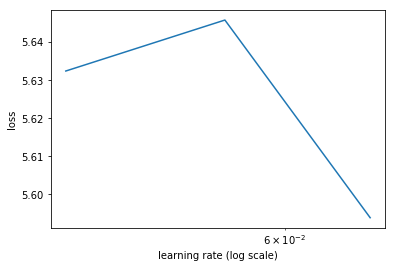

In [145]:
learner.sched.plot()

In [146]:
lrs=0.01

In [147]:
learner.fit(lrs, 4, wds=wd, use_clr=(20,10), cycle_len=10)

epoch      trn_loss   val_loss   accuracy                 
    0      5.315913   4.263407   0.232632  
    1      4.750124   3.846459   0.291579                 
    2      4.410567   3.56172    0.323158                 
    3      4.150157   3.365438   0.334737                 
    4      3.946539   3.282152   0.344211                 
    5      3.754025   3.199284   0.341053                 
    6      3.570512   3.175725   0.369474                 
    7      3.408397   3.126712   0.373684                 
    8      3.278361   3.089606   0.377895                 
    9      3.159798   3.096392   0.383158                 
    10     3.083657   3.172356   0.374737                 
    11     3.075109   3.270071   0.347368                 
    12     3.03501    3.213439   0.363158                 
    13     2.96425    3.169447   0.38                     
    14     2.873018   3.201772   0.378947                 
    15     2.783973   3.20988    0.368421                 
    16     2

[array([3.60855]), 0.3684210479259491]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [148]:
learner.save('lm1')

In [149]:
learner.save_encoder('lm1_enc')

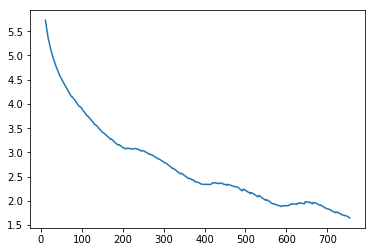

In [150]:
learner.sched.plot_loss()

# Predict The Dialog in The Room 2!

In [151]:
def proc_str(s): return TEXT.preprocess(TEXT.tokenize(s))
def num_str(s): return TEXT.numericalize([proc_str(s)])

In [152]:
m=learner.model

In [153]:
def sample_model(m, s, l=50):
    s_toks = Tokenizer().proc_text(s)
    s_nums = [stoi[i] for i in s_toks]
    s_var = V(np.array(s_nums))[None]

    m[0].bs=1
    m.eval()
    m.reset()

    res, *_ = m(s_var)
    #print('...', end='')
    words = ""
    for i in range(l):
        r = torch.multinomial(res[-1].exp(), 2)
        #r = torch.topk(res[-1].exp(), 2)[1]
        if r.data[0] == 0:
            r = r[1]
        else:
            r = r[0]
        
        word = itos[to_np(r)[0]]
        res, *_ = m(r[0].unsqueeze(0))
        #print(word, end=' ')
        words += word + ' '
    m[0].bs=bs
    return(words)

In [154]:
the_new_room = "Meanwhile in San Francisco: " + sample_model(m, 'Meanwhile in San Francisco: ', 20000)

In [155]:
#import csv

In [156]:
#with open("the_room_2.csv",'wb') as resultFile:
#    wr = csv.writer(the_new_room, dialect='excel')
#    wr.writerow(the_new_room)

In [157]:
text_file = open("Output.txt", "w")
text_file.write("%s" % the_new_room)
text_file.close()

In [ ]:
!wd

# Character Level Predictors

In [ ]:


def get_next(inp):
    idxs = num_str(inp)
    res, *_ = m(VV(idxs.transpose(0,1)))
    r = torch.multinomial(res[-1].exp(), 2)
    if r.data[0] == 0:
        r = r[1]
    else:
        r = r[0]
    return TEXT.vocab.itos[to_np(r)[0]]



In [ ]:
def get_next_n(inp, n):
    res_lst = inp.split(' ')
    try:
        for i in range(n):
            c = get_next(inp)
            res_lst += [c]
            inp_lst = inp.split(' ')
            inp_lst += [c]
            inp = """ """.join(inp_lst[1:])
        return """ """.join(res_lst)
    except:
        print(res_lst)
        print(c)
        print(inp)

In [ ]:
m = learner.model
m.eval();

In [ ]:
print(get_next_n(ss, 500))